A notebook which contains an evaluation of the SalishSeaCast model within PugetSound for the year 2018. More specifically, it compares Observed data on chlorophyll and nutrient concentrations collected from bottle data and compares it to various model phytoplankon outputs. This evaluation includes scatter plots visualizing the similarity of observed and model data as well as tables of evaluation statistics.

In [1]:
import sys
sys.path.append('/ocean/kflanaga/MEOPAR/analysis-keegan/notebooks/Tools')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import netCDF4 as nc
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import gsw 
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import matplotlib.dates as mdates
import cmocean as cmo
import scipy.interpolate as sinterp
import pickle
import cmocean
import json
import f90nml
import Keegan_eval_tools as ket
from collections import OrderedDict
from matplotlib.colors import LogNorm

fs=16
mpl.rc('xtick', labelsize=fs)
mpl.rc('ytick', labelsize=fs)
mpl.rc('legend', fontsize=fs)
mpl.rc('axes', titlesize=fs)
mpl.rc('axes', labelsize=fs)
mpl.rc('figure', titlesize=fs)
mpl.rc('font', size=fs)
mpl.rc('font', family='sans-serif', weight='normal', style='normal')

import warnings
#warnings.filterwarnings('ignore')
from IPython.display import Markdown, display

%matplotlib inline

In [3]:
years=[2018,2019]
year=2019
modelversion='nowcast-green.201905'
PATH= '/results2/SalishSea/nowcast-green.201905/'
datadir='/ocean/eolson/MEOPAR/obs/WADE/ptools_data/ecology'

In [4]:
display(Markdown('''## Year: 2019'''))

## Year: 2019

In [5]:
display(Markdown('''### Model output: '''+ PATH))

### Model output: /results2/SalishSea/nowcast-green.201905/

In [6]:
##### Loading in pickle file data
saveloc='/ocean/kflanaga/MEOPAR/savedData'
with open(os.path.join(saveloc,f'data_nutchl_{modelversion}_2018-2019.pkl'),'rb') as hh:
    data=pickle.load(hh)

In [7]:
#Adding extra columns to assist in analysis.
data['log_Chl']=ket.logt(data['Chla_Lab'])
data['log_mod_diatoms']=ket.logt(data['mod_diatoms']*1.8)
data['log_mod_ciliates']=ket.logt(data['mod_ciliates']*1.8)
data['log_mod_flagellates']=ket.logt(data['mod_flagellates']*1.8)
data['mod_Chl']=((data['mod_diatoms']*1.8)+(data['mod_ciliates']*1.8)+(data['mod_flagellates']*1.8))
data['log_mod_Chl']=ket.logt((data['mod_diatoms']*1.8)+(data['mod_ciliates']*1.8)+(data['mod_flagellates']*1.8))

datstat=dict()
for ind, istation in enumerate(data.Station.unique()):
    datstat[istation]=data.loc[data.Station == istation]
    
datreg=dict()
for iregion in data.Basin.unique():
    datreg[iregion] = data.loc[data.Basin==iregion]   

In [8]:
# Creating seperate dataframes for each season (includes only data above 15 metre depth.)
iz=(data.Z<15)
DJF=data.loc[iz&(data.dtUTC>=dt.datetime(years[0],12,1))&(data.dtUTC<=dt.datetime(years[1],3,1)),:]
MAM=data.loc[iz&(data.dtUTC<=dt.datetime(years[1],6,1))&(data.dtUTC>dt.datetime(years[1],3,1)),:]
JJA=data.loc[iz&(data.dtUTC<=dt.datetime(years[1],9,1))&(data.dtUTC>dt.datetime(years[1],6,1)),:]
SON=data.loc[iz&(data.dtUTC>dt.datetime(years[1],9,1))&(data.dtUTC<=dt.datetime(years[1],11,30)),:]

In [9]:
data=data.loc[(data.dtUTC>=dt.datetime(years[0],12,1))&(data.dtUTC<=dt.datetime(years[1],11,30)),:]

In [10]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({'z < 15 m':data.loc[data.Z<15],
                      '15 m < z < 22 m':data.loc[(data.Z>=15)&(data.Z<22)],
                      'z >= 22 m':data.loc[data.Z>=22],
                      'z > 50 m':data.loc[data.Z>50],
                      'all':data,
                      'z < 15 m, DJF':DJF,
                      'z < 15 m, MAM':MAM,
                      'z < 15 m, JJA':JJA,
                      'z < 15 m, SON': SON,})
for iregion in data.Basin.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['z < 15 m', '15 m < z < 22 m', 'z >= 22 m', 'z > 50 m', 'all', 'z < 15 m, DJF', 'z < 15 m, MAM', 'z < 15 m, JJA', 'z < 15 m, SON', 'Whidbey Basin', 'Admiralty Inlet', 'Strait of Juan de Fuca', 'Strait of Georgia', 'Hood Canal Basin', 'South Basin', 'Main Basin'])

## Map of observation locations in each basin

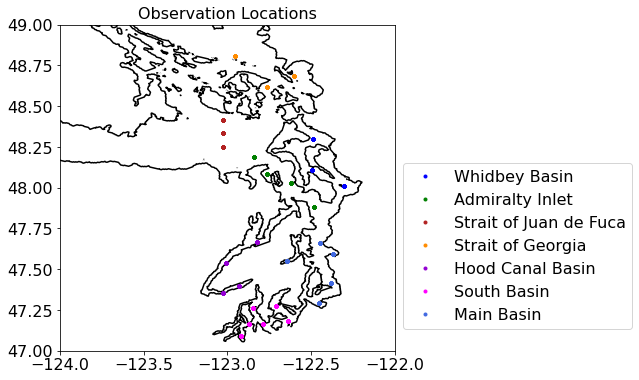

In [11]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/data/vdo/MEOPAR/NEMO-forcing/grid/bathymetry_201702.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1)
colors=('blue','green','firebrick','darkorange','darkviolet','fuchsia',
        'royalblue','darkgoldenrod','mediumspringgreen','deepskyblue')
for ind, iregion in enumerate(data.Basin.unique()):
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
            color = colors[ind], label=iregion)
ax.set_ylim(47, 49)
ax.legend(bbox_to_anchor=[1,.6,0,0])
ax.set_xlim(-124, -122);
ax.set_title('Observation Locations');

# Nitrate

### Table containing evaluation statistics for relevant subsets

In [12]:
# Defining variables needed for nitrate evaluations
obsvar='NO23'
modvar='mod_nitrate'
seasons=[DJF,MAM,JJA,SON]

In [13]:
statsDict=dict()
statsDict['NO23']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict['NO23'][isub]=dict()
    var=statsDict['NO23'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['NO23'],level='Subset',suborder=list(statsubs.keys()))
tbl

z < 15 m
15 m < z < 22 m
z >= 22 m
z > 50 m
all
z < 15 m, DJF
z < 15 m, MAM
z < 15 m, JJA
z < 15 m, SON
Whidbey Basin
Admiralty Inlet
Strait of Juan de Fuca
Strait of Georgia
Hood Canal Basin
South Basin
Main Basin


### Model vs Observed comparisons by depth and region

In [14]:
data.NO23.unique()

array([10.4092, 12.9439, 20.6759, ..., 24.4446, 25.1038, 26.7684])

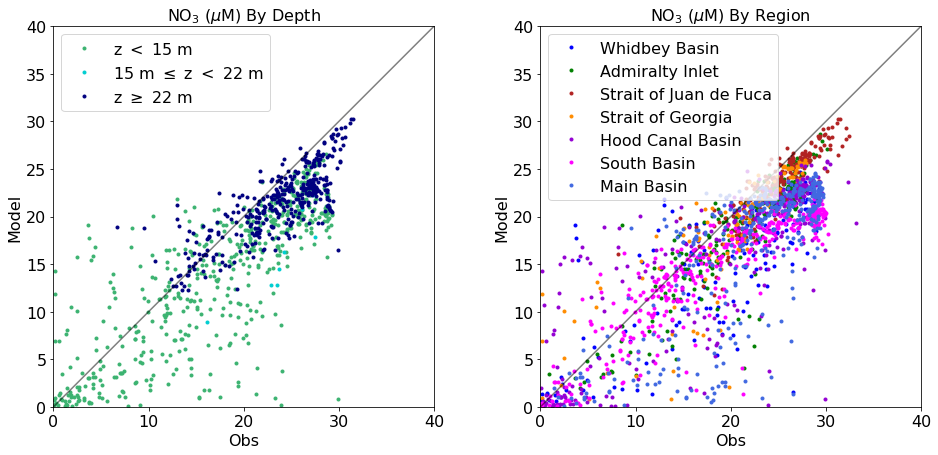

In [15]:
lims=(0,40)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('NO$_3$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('NO$_3$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

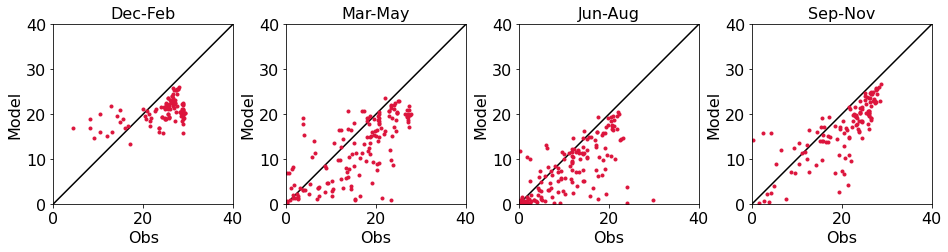

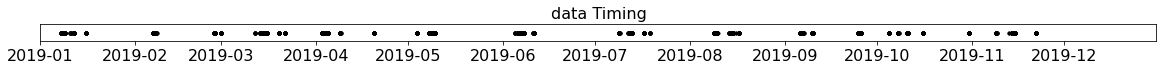

In [16]:
seasons=[DJF,MAM,JJA,SON]

fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

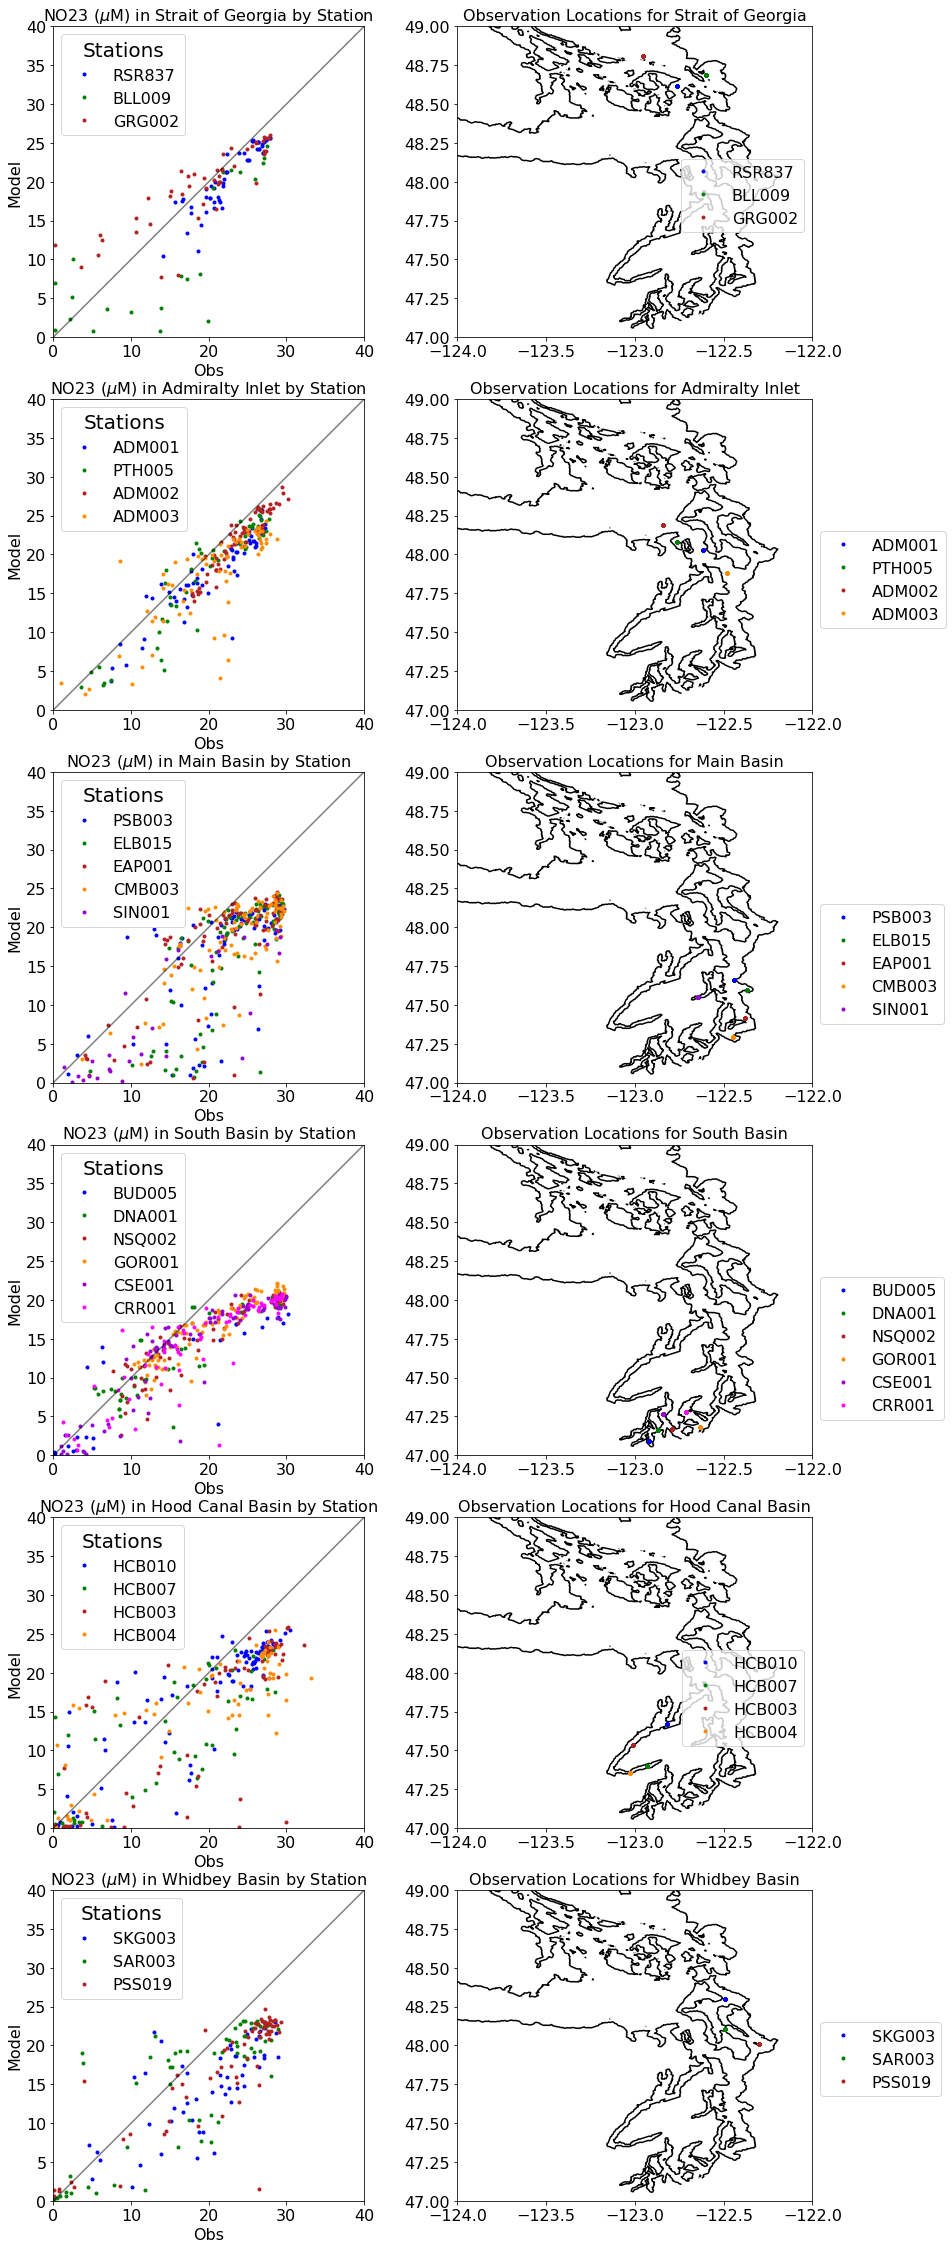

In [17]:
obsvar='NO23'
modvar='mod_nitrate'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

# Dissolved Silica

### Table containing evaluation statistics for relevant subsets

In [18]:
# Defining Variables needed for silica determination 
obsvar='Si'
modvar='mod_silicon'
seasons=[DJF,MAM,JJA,SON]

In [19]:
statsDict['Si']=OrderedDict()
for isub in statsubs:
    statsDict['Si'][isub]=dict()
    var=statsDict['Si'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['Si'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

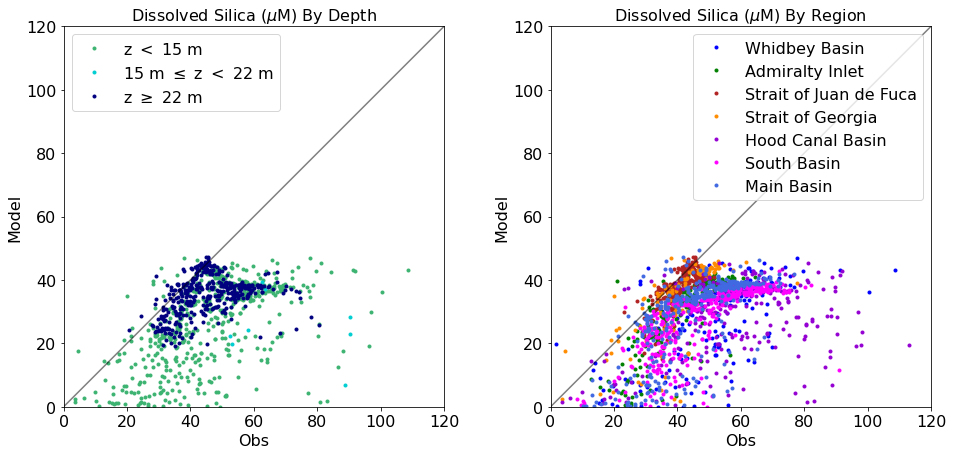

In [20]:
lims=(0,120)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Dissolved Silica ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Dissolved Silica ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

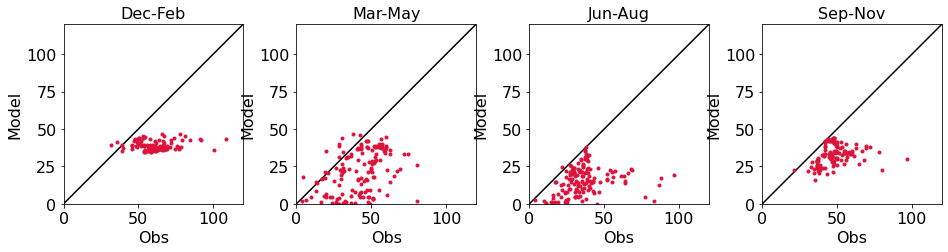

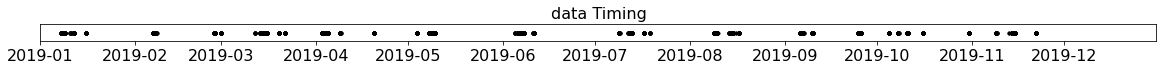

In [21]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

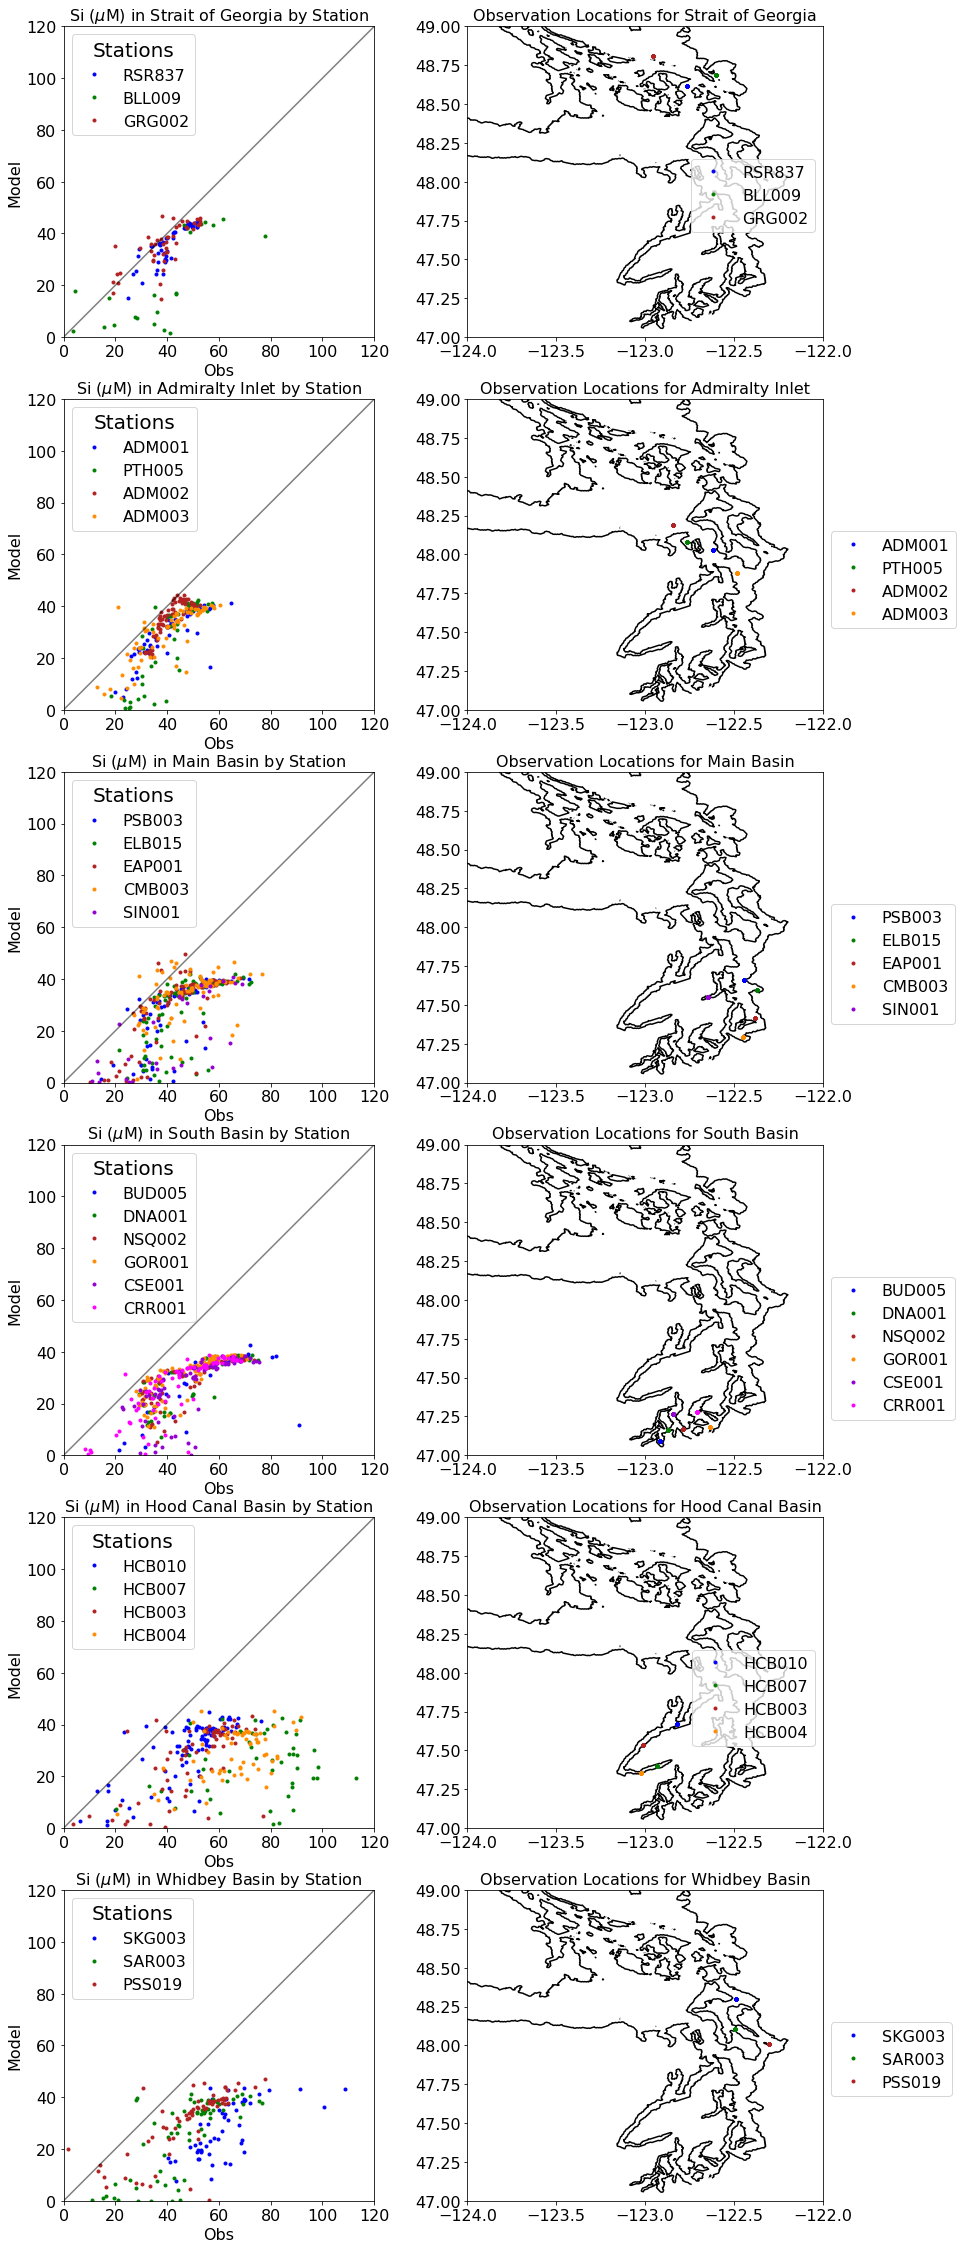

In [22]:
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

### Profiles of NO3 and Dissolved Silica

Text(0.5, 1.0, 'dSi')

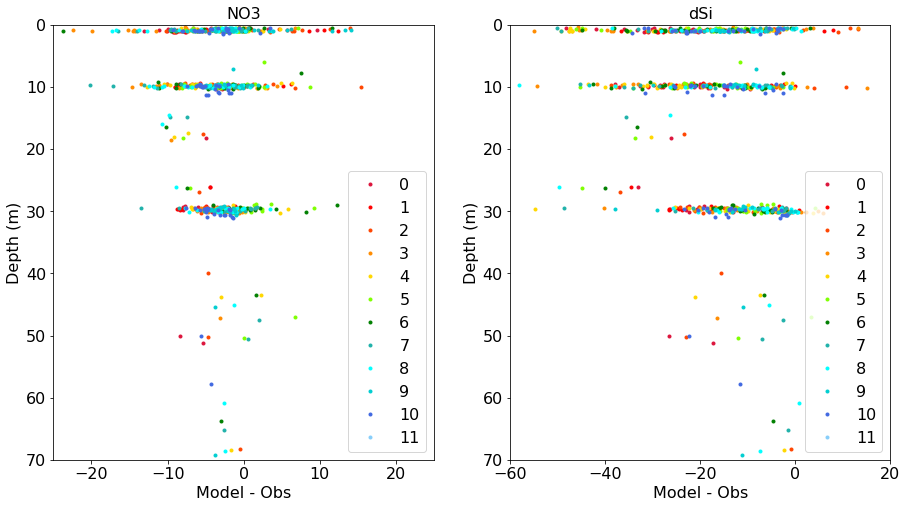

In [23]:
start_date = dt.datetime(year,1,1)
end_date = dt.datetime(year,12,31)

fig, ax = plt.subplots(1,2,figsize = (15,8))
cols=('crimson','red','orangered','darkorange','gold','chartreuse','green','lightseagreen','cyan',
      'darkturquoise','royalblue','lightskyblue','blue','darkblue','mediumslateblue','blueviolet',
      'darkmagenta','fuchsia','deeppink','pink')
ii0=start_date
for ii in range(0,int((end_date-start_date).days/30)):
    iii=(data.dtUTC>=(start_date+dt.timedelta(days=ii*30)))&(data.dtUTC<(start_date+dt.timedelta(days=(ii+1)*30)))
    ax[0].plot(data.loc[iii,['mod_nitrate']].values-data.loc[iii,['NO23']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
    ax[1].plot(data.loc[iii,['mod_silicon']].values-data.loc[iii,['Si']].values, data.loc[iii,['Z']].values, 
        '.', color = cols[ii],label=str(ii))
for axi in (ax[0],ax[1]):
    axi.legend(loc=4)
    axi.set_ylim(70,0)
    axi.set_ylabel('Depth (m)')
ax[0].set_xlabel('Model - Obs')
ax[1].set_xlabel('Model - Obs')
ax[0].set_xlim(-25,25)
ax[1].set_xlim(-60,20)
ax[0].set_title('NO3')
ax[1].set_title('dSi')

# dSi:NO3 Ratios

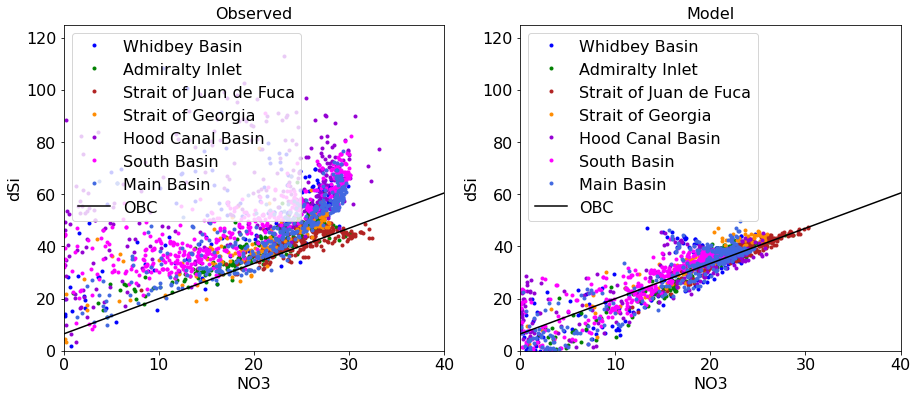

In [24]:
fig,ax=plt.subplots(1,2,figsize=(15,6))
for ind,iregion in enumerate(data.Basin.unique()):
    p1=ax[0].plot(datreg[iregion]['NO23'],datreg[iregion]['Si'],'.',
                  color=colors[ind],label=iregion)
ax[0].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')  
ax[0].set_title('Observed')
ax[0].set_xlabel('NO3')
ax[0].set_ylabel('dSi')
ax[0].set_xlim(0,40)
ax[0].set_ylim(0,125)
ax[0].legend()

for ind,iregion in enumerate(data.Basin.unique()):
    p=ax[1].plot(datreg[iregion]['mod_nitrate'],datreg[iregion]['mod_silicon'],'.',  
                  color=colors[ind],label=iregion)
ax[1].plot(np.arange(0,41),1.35*np.arange(0,41)+6.46,'k-',label='OBC')
ax[1].set_title('Model')
ax[1].set_xlabel('NO3')
ax[1].set_ylabel('dSi')
ax[1].set_xlim(0,40)
ax[1].set_ylim(0,125)
ax[1].legend()
#ax[0].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')
#ax[1].plot(np.arange(0,35),1.3*np.arange(0,35),'k-')

# NH4

### Table containing evaluation statistics for relevant subsets

In [25]:
# Defining Variables for determining Ammonium
obsvar='Amm'
modvar='mod_ammonium'
seasons=[DJF,MAM,JJA,SON]

In [26]:
statsDict['NH4']=OrderedDict()
for isub in statsubs:
    statsDict['NH4'][isub]=dict()
    var=statsDict['NH4'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]],
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict['NH4'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Model vs Observed comparisons by depth and region

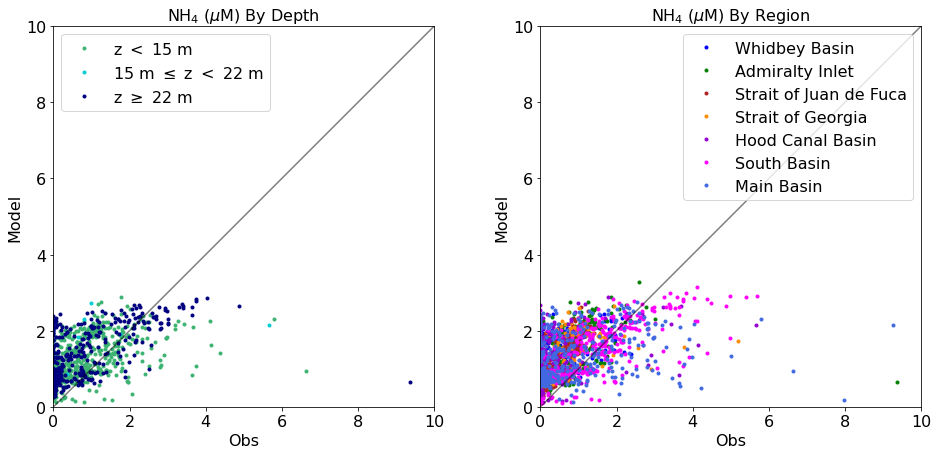

In [27]:
lims=(0,10)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('NH$_4$ ($\mu$M) By Depth')

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('NH$_4$ ($\mu$M) By Region');

### Model vs Observed comparisons for individual seasons

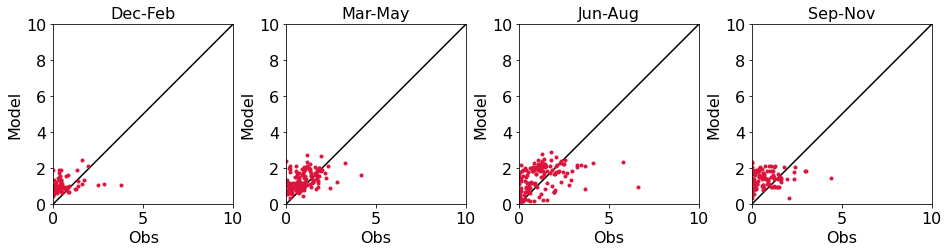

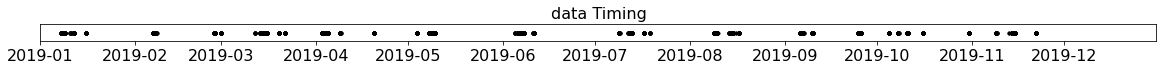

In [28]:
fig, ax = plt.subplots(1,4,figsize = (16,3.3))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data Timing')
ax.yaxis.set_visible(False)

### Model vs Observed comparisons for individual regions and stations

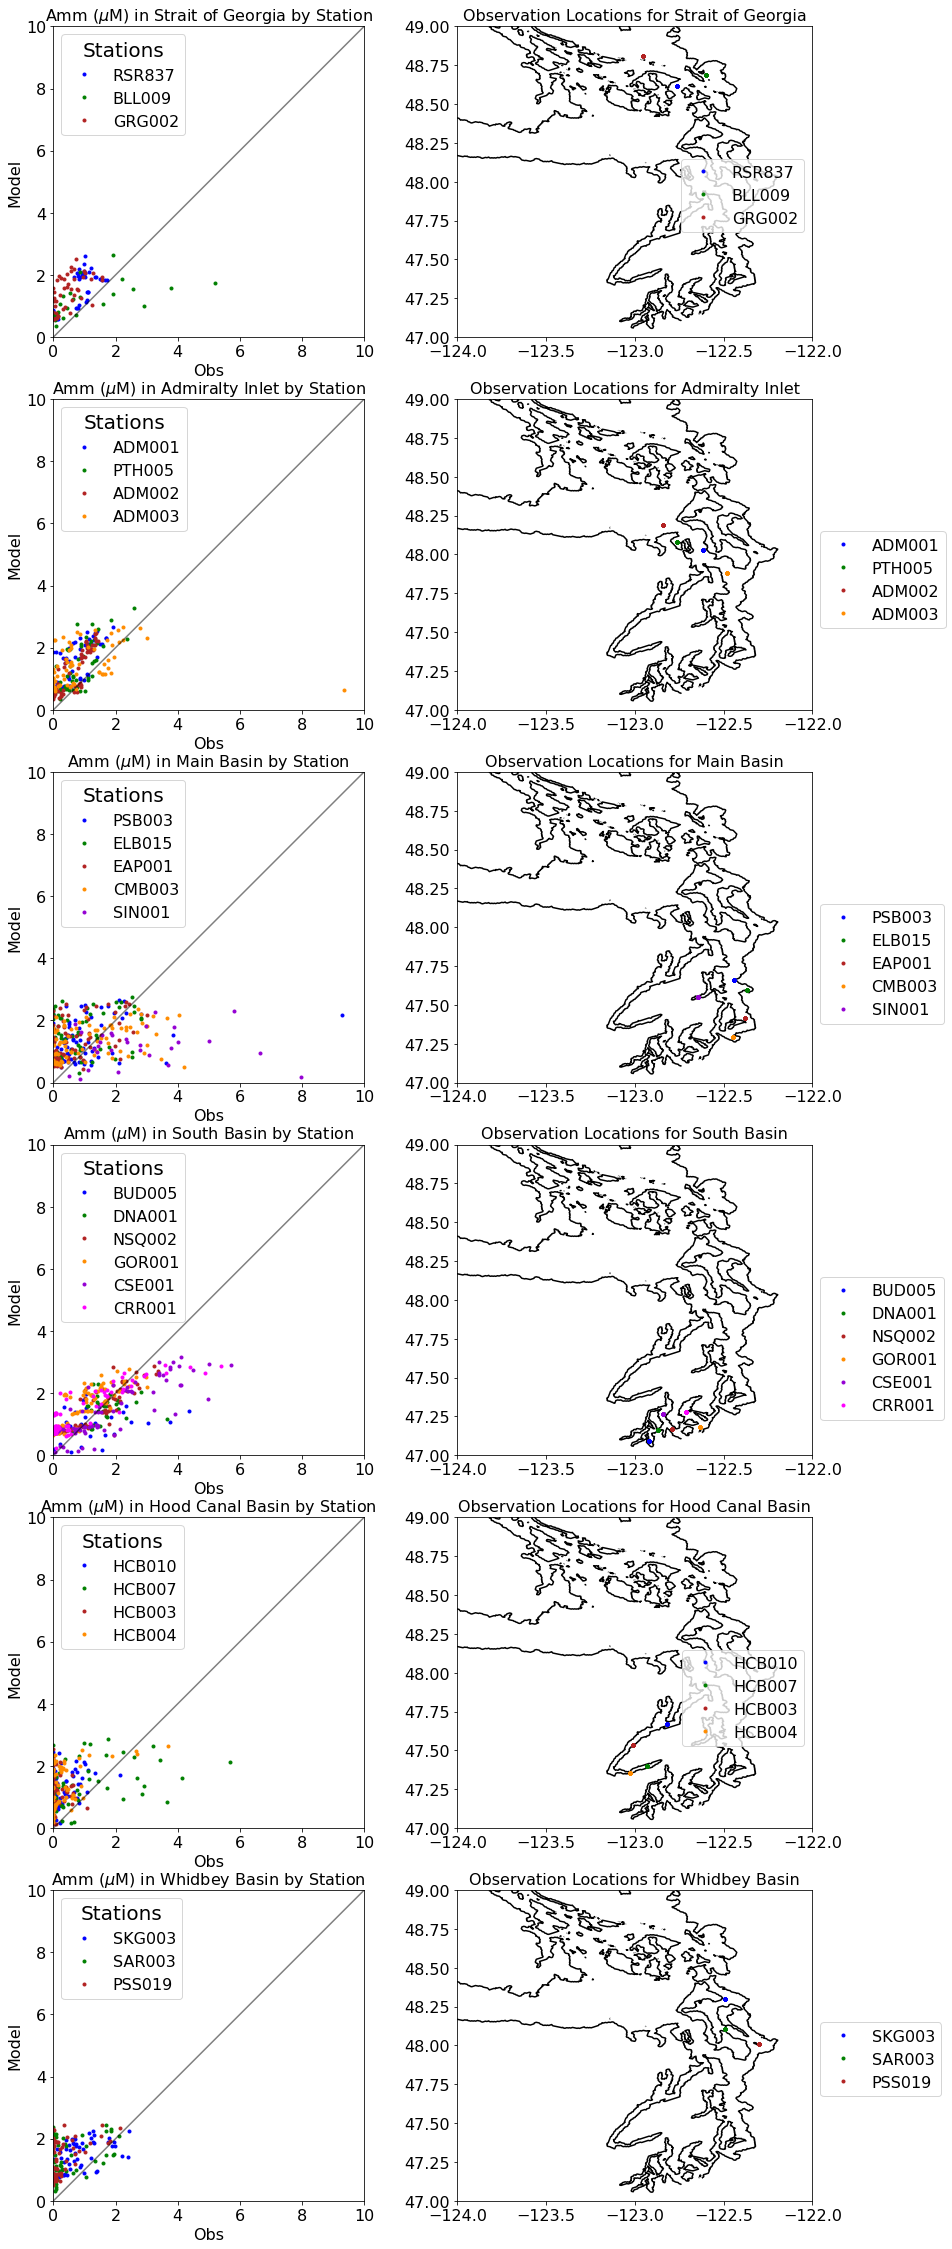

In [29]:
obsvar='Amm'
modvar='mod_ammonium'
regions=['Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims)

In [30]:
tbl,tdf=et.displayStats(statsDict,level='Variable',suborder=list(statsubs.keys()))
tbl

# Chlorophyll

# Observed Chlorophyll vs Model Phytoplankton

## Model Diatoms vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets

In [31]:
#Setting variables for Chlorophyll.
obsvar='Chla_Lab'
modvar='mod_diatoms'
seasons=[DJF,MAM,JJA,SON]

In [32]:
statsDict_Chl={year:dict()}
statsDict_Chl['Diatoms']=OrderedDict()
for isub in statsubs:
    statsDict_Chl['Diatoms'][isub]=dict()
    var=statsDict_Chl['Diatoms'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]], 
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['Diatoms'],level='Subset',suborder=list(statsubs.keys()))
tbl

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ ()]')

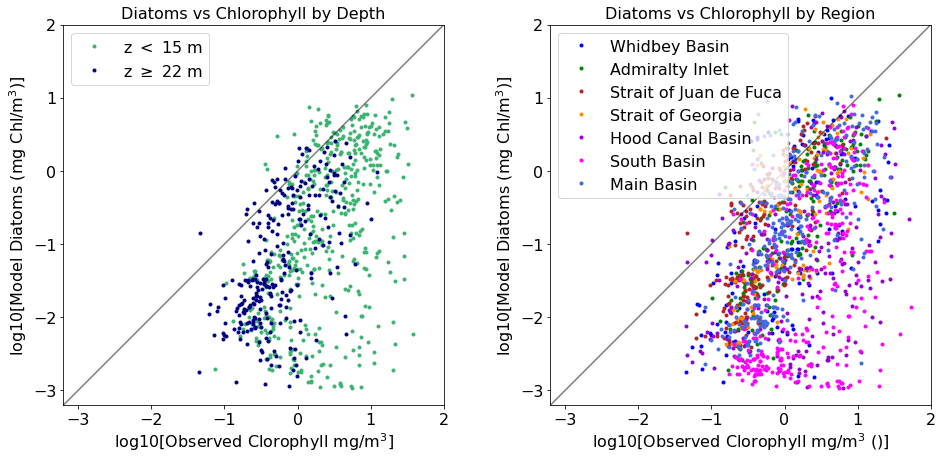

In [33]:
obsvar='log_Chl'
modvar='log_mod_diatoms'
lims=(-3.2,2)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Diatoms vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$]')   

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Diatoms vs Chlorophyll by Region');
ax[1].set_ylabel('log10[Model Diatoms (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ ()]') 

### Model vs Observed comparisons for individual regions and stations

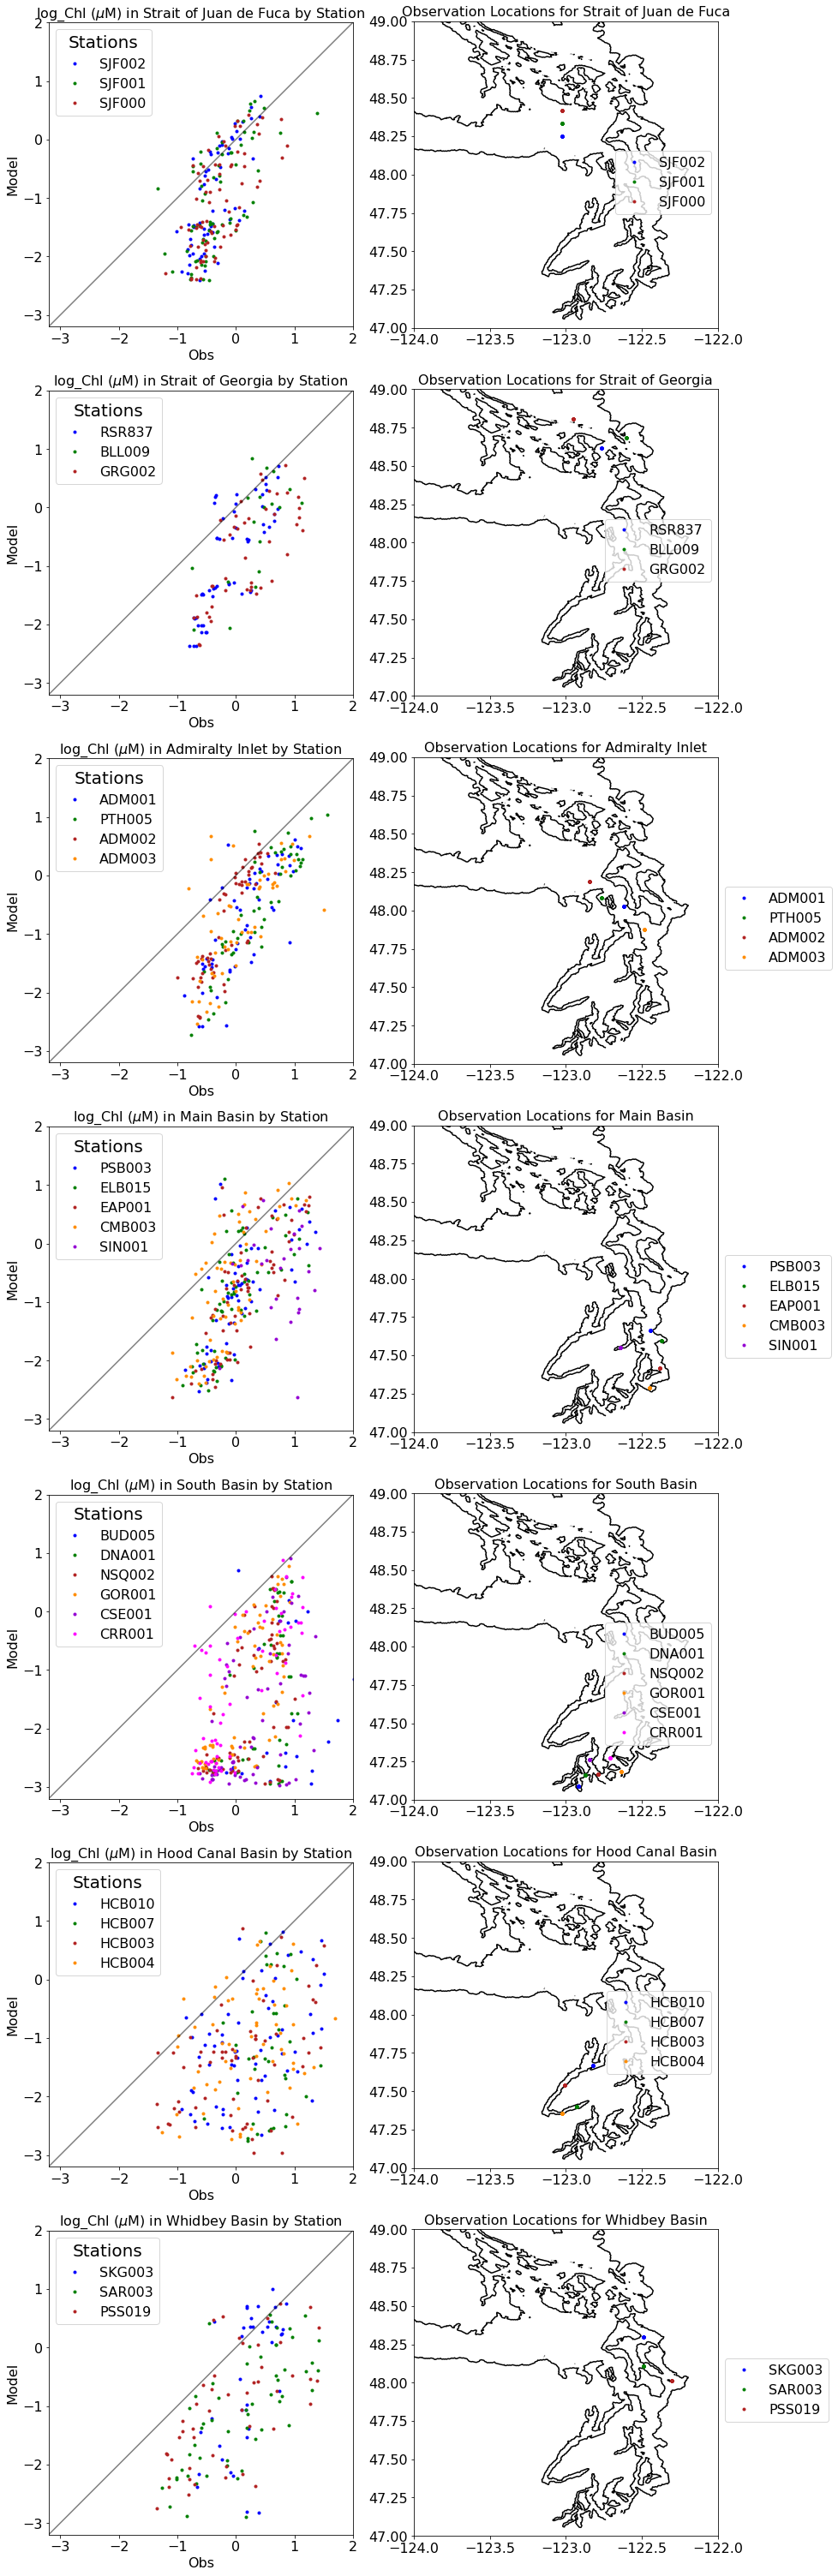

In [34]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims,figsize=(14,54))

### Model vs observed comparisons for multiple seasons

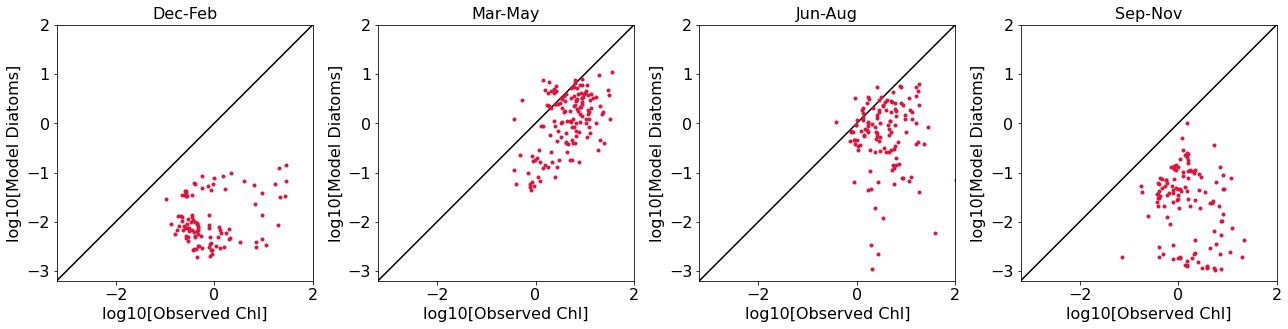

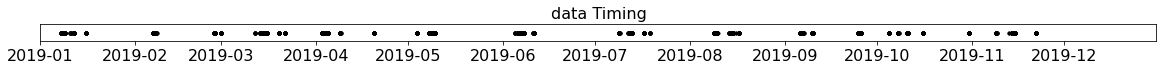

In [35]:
seasons=[DJF,MAM,JJA,SON]
fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
for i in range(4):
        ax[i].set_ylabel('log10[Model Diatoms]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data Timing')
ax.yaxis.set_visible(False)

## Model Ciliates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [36]:
obsvar='Chla_Lab'
modvar='mod_ciliates'

statsDict_Chl['Ciliates']=OrderedDict()
for isub in statsubs:
    statsDict_Chl['Ciliates'][isub]=dict()
    var=statsDict_Chl['Ciliates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]], 
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['Ciliates'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ ()]')

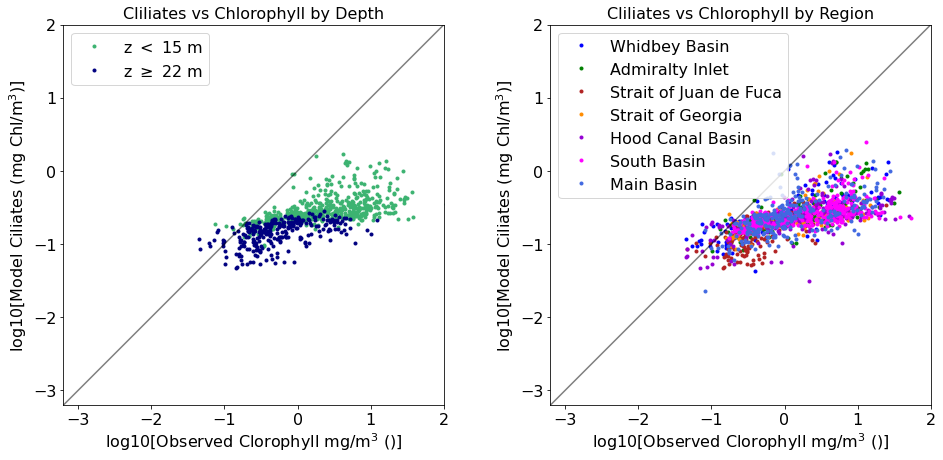

In [37]:
obsvar='log_Chl'
modvar='log_mod_ciliates'
lims=(-3.2,2)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Cliliates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ ()]')  

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Cliliates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Ciliates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ ()]') 

### Model vs Observed comparisons for individual regions and stations

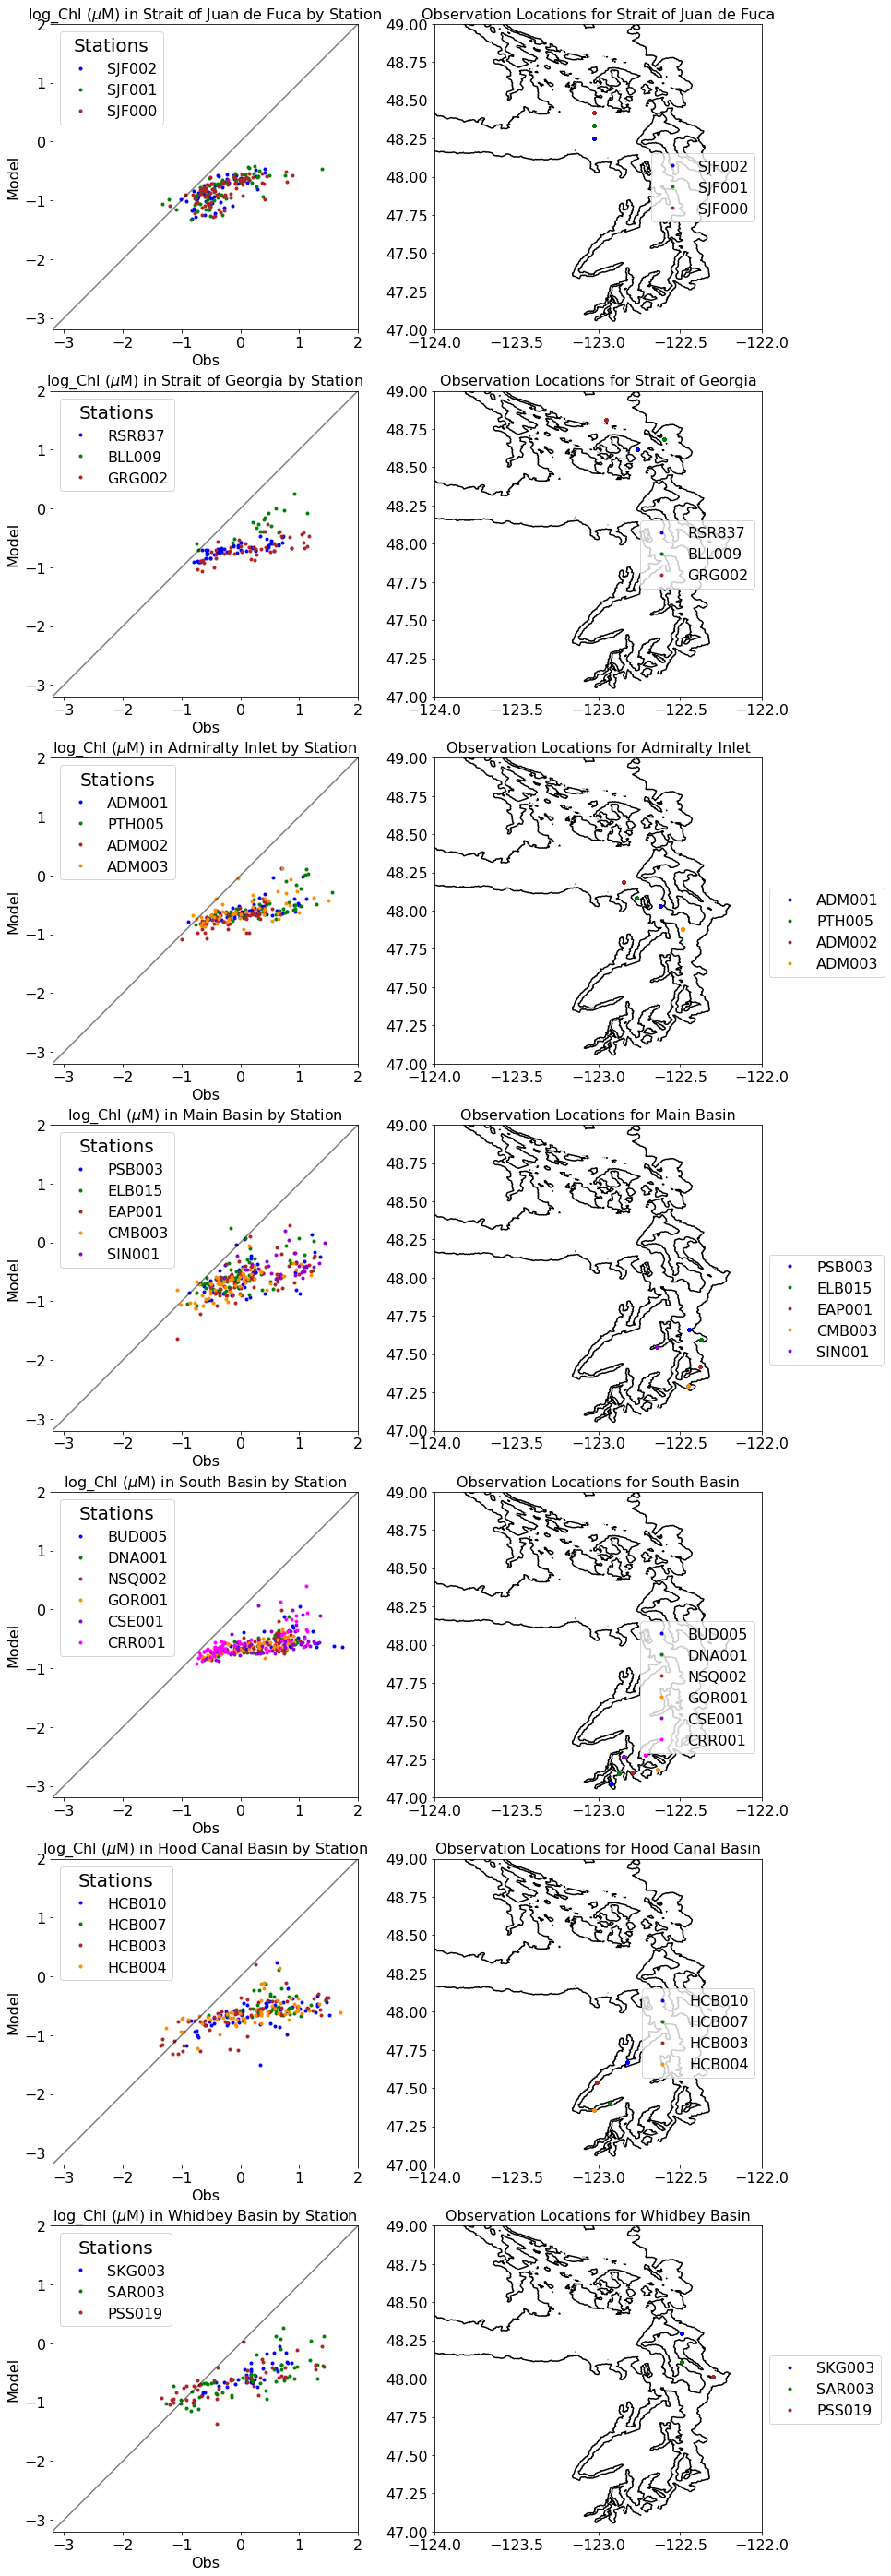

In [38]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims,figsize=(14,50))

## Model Ciliates vs observed Chlorophyll comparisons for multiple seasons

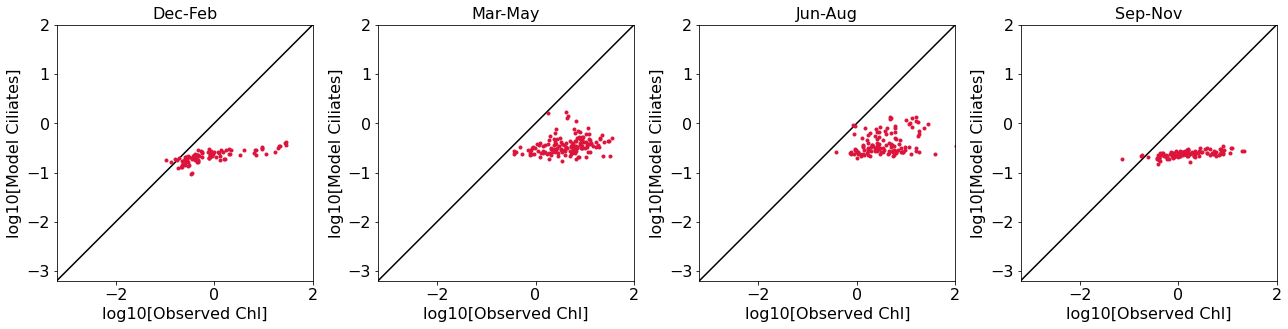

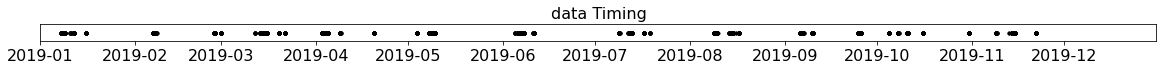

In [39]:
seasons=[DJF,MAM,JJA,SON]
fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
for i in range(4):
        ax[i].set_ylabel('log10[Model Ciliates]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data Timing')
ax.yaxis.set_visible(False)

## Model Flagellates vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [40]:
obsvar='Chla_Lab'
modvar='mod_flagellates'

statsDict_Chl['Flagellates']=OrderedDict()
for isub in statsubs:
    statsDict_Chl['Flagellates'][isub]=dict()
    var=statsDict_Chl['Flagellates'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]], 
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['Flagellates'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ ()]')

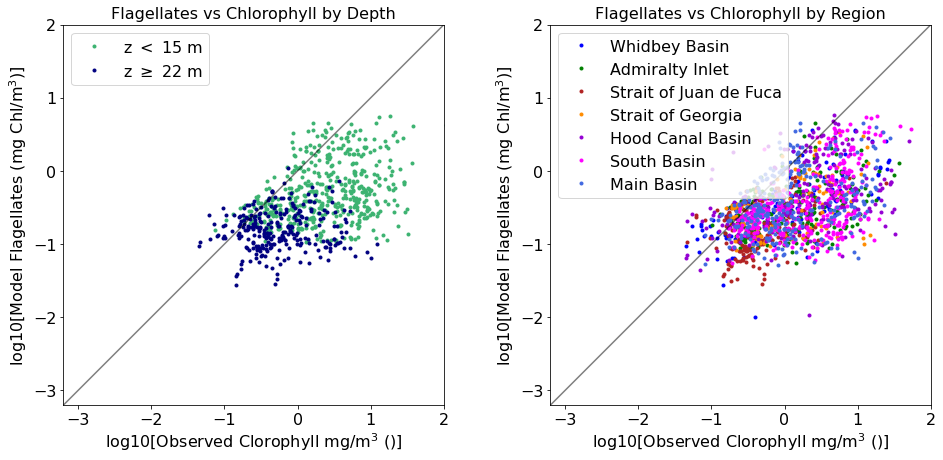

In [41]:
obsvar='log_Chl'
modvar='log_mod_flagellates'
lims=(-3.2,2)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Flagellates vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ ()]')  

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Flagellates vs Chlorophyll by Region')
ax[1].set_ylabel('log10[Model Flagellates (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ ()]') 

### Model vs Observed comparisons for individual regions and stations

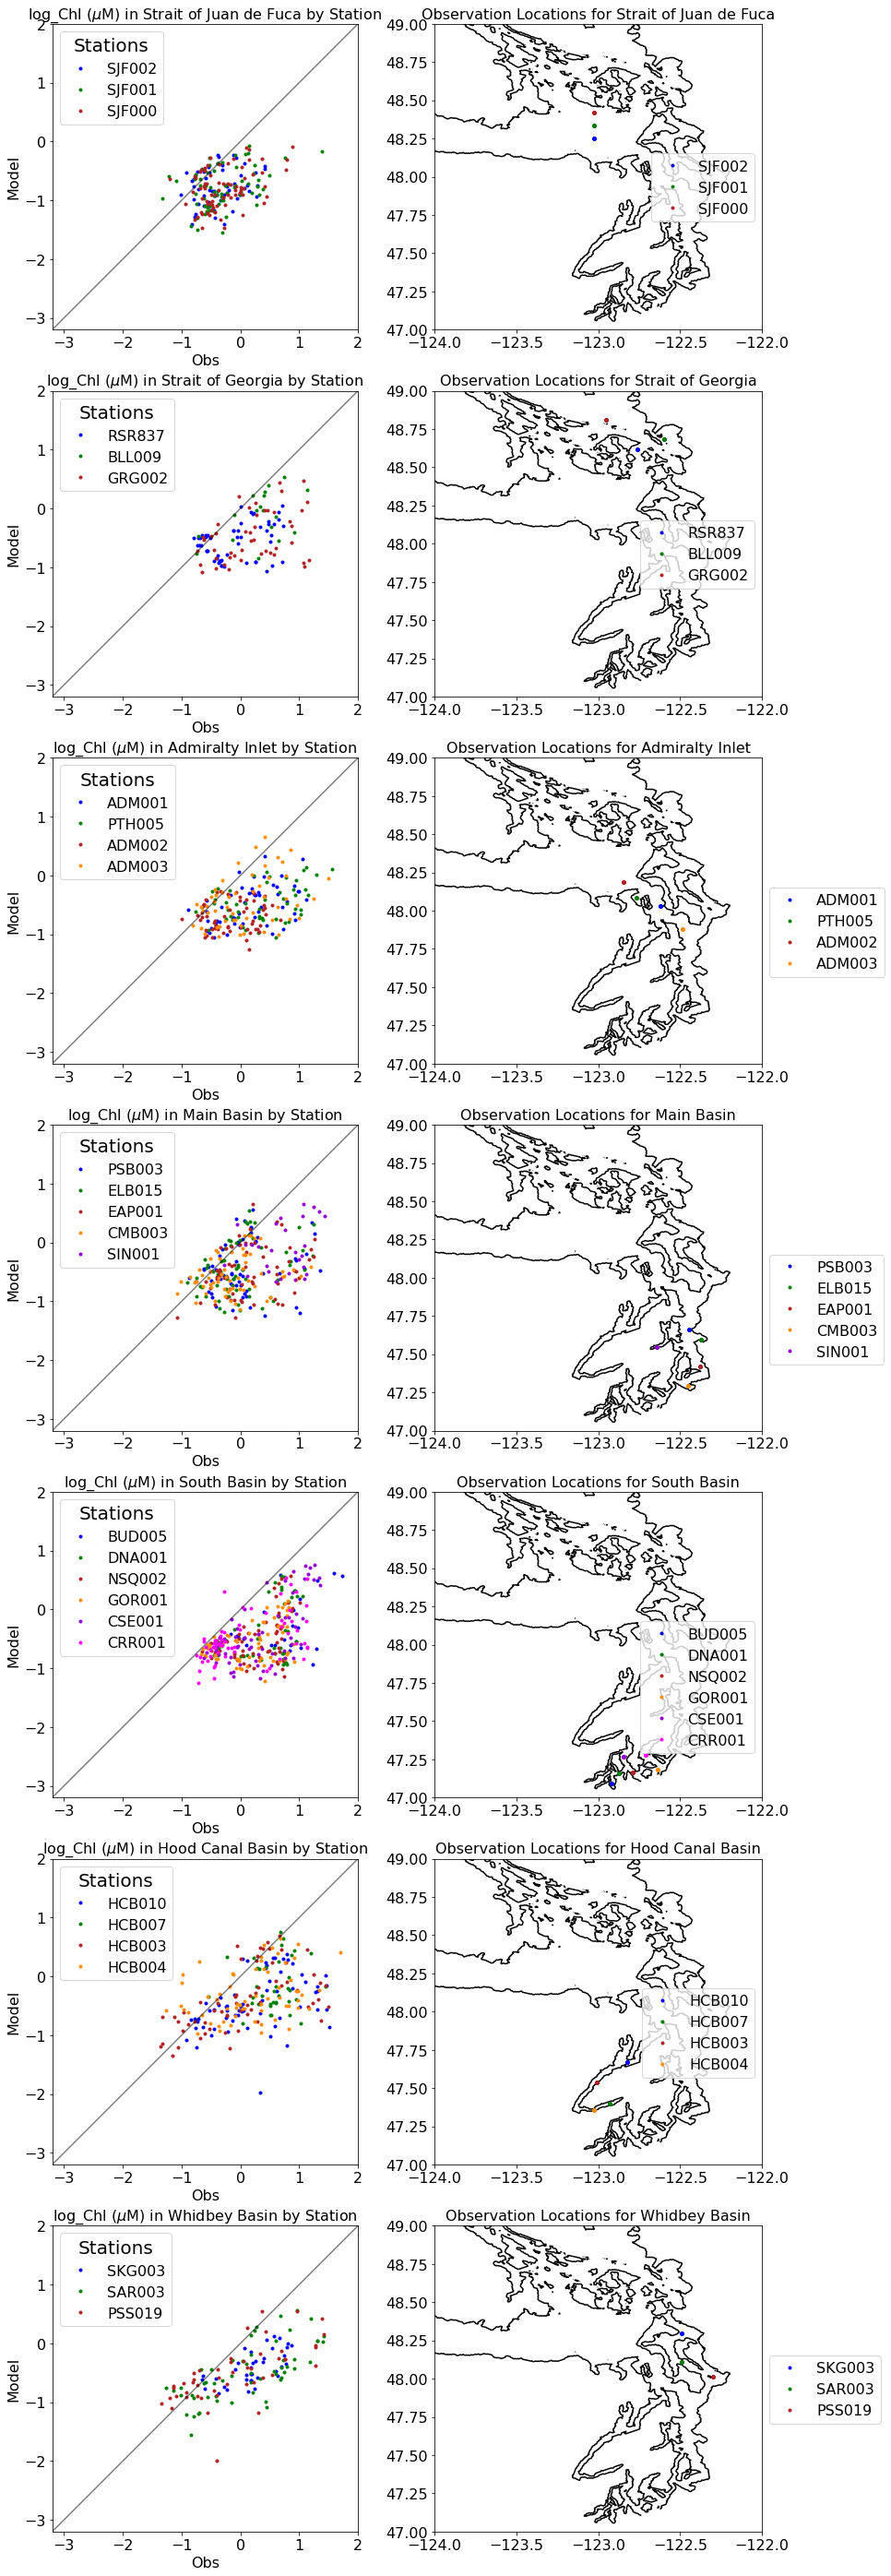

In [42]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims,figsize=(14,50))

### Model flagellates vs observed Chlorophyll comparisons for multiple seasons

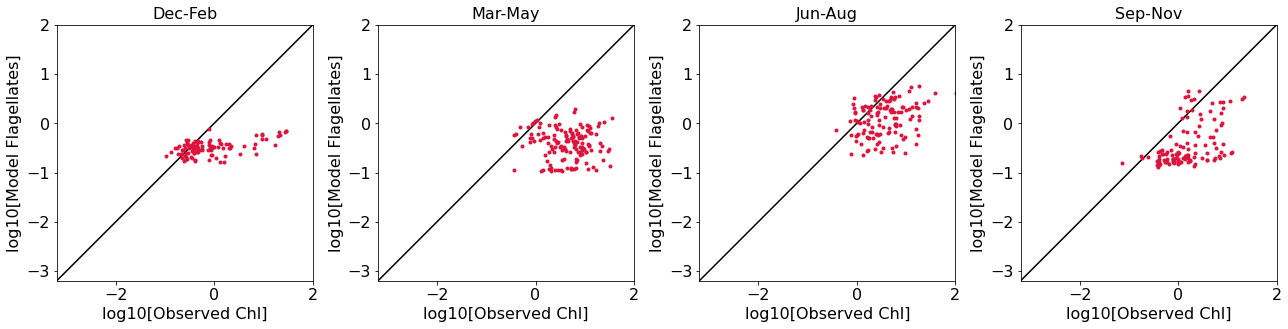

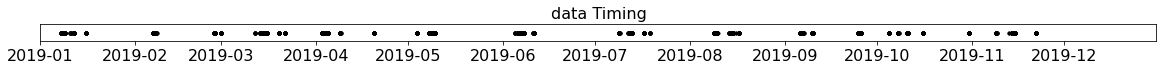

In [43]:
seasons=[DJF,MAM,JJA,SON]
fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
for i in range(4):
        ax[i].set_ylabel('log10[Model Flagellates]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data Timing')
ax.yaxis.set_visible(False)

## All Model Phytoplankton vs Observed Chlorophyll
### Table containing evaluation statistics for relevant subsets. 

In [44]:
obsvar='Chla_Lab'
modvar='mod_Chl'

statsDict_Chl['All']=OrderedDict()
for isub in statsubs:
    statsDict_Chl['All'][isub]=dict()
    var=statsDict_Chl['All'][isub]
    var['N'],mmean,omean,var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar]], 
                                                                     statsubs[isub].loc[:,[modvar]])
tbl,tdf=et.displayStats(statsDict_Chl['All'],level='Subset',suborder=list(statsubs.keys()))
tbl

### Comparisons by depth and region

Text(0.5, 0, 'log10[Observed Clorophyll mg/m$^3$ ()]')

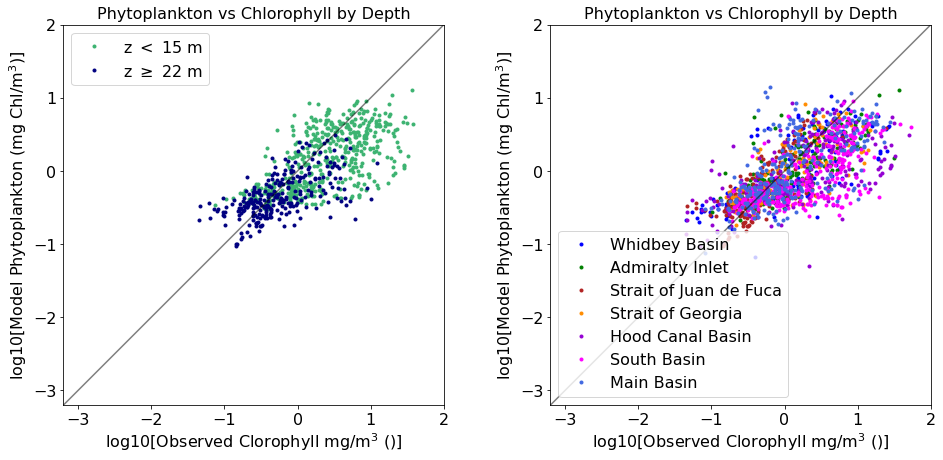

In [45]:
obsvar='log_Chl'
modvar='log_mod_Chl'
lims=(-3.2,2)

fig, ax = plt.subplots(1,2,figsize = (16,7))
ps,l=ket.byDepth(ax[0],data,obsvar,modvar,lims)
ax[0].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[0].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[0].set_xlabel('log10[Observed Clorophyll mg/m$^3$ ()]') 

ps,l=ket.byRegion(ax[1],data,datreg,obsvar,modvar,lims)
ax[1].set_title('Phytoplankton vs Chlorophyll by Depth')
ax[1].set_ylabel('log10[Model Phytoplankton (mg Chl/m$^3$)]')
ax[1].set_xlabel('log10[Observed Clorophyll mg/m$^3$ ()]') 

### Model vs Observed comparisons for individual regions and stations

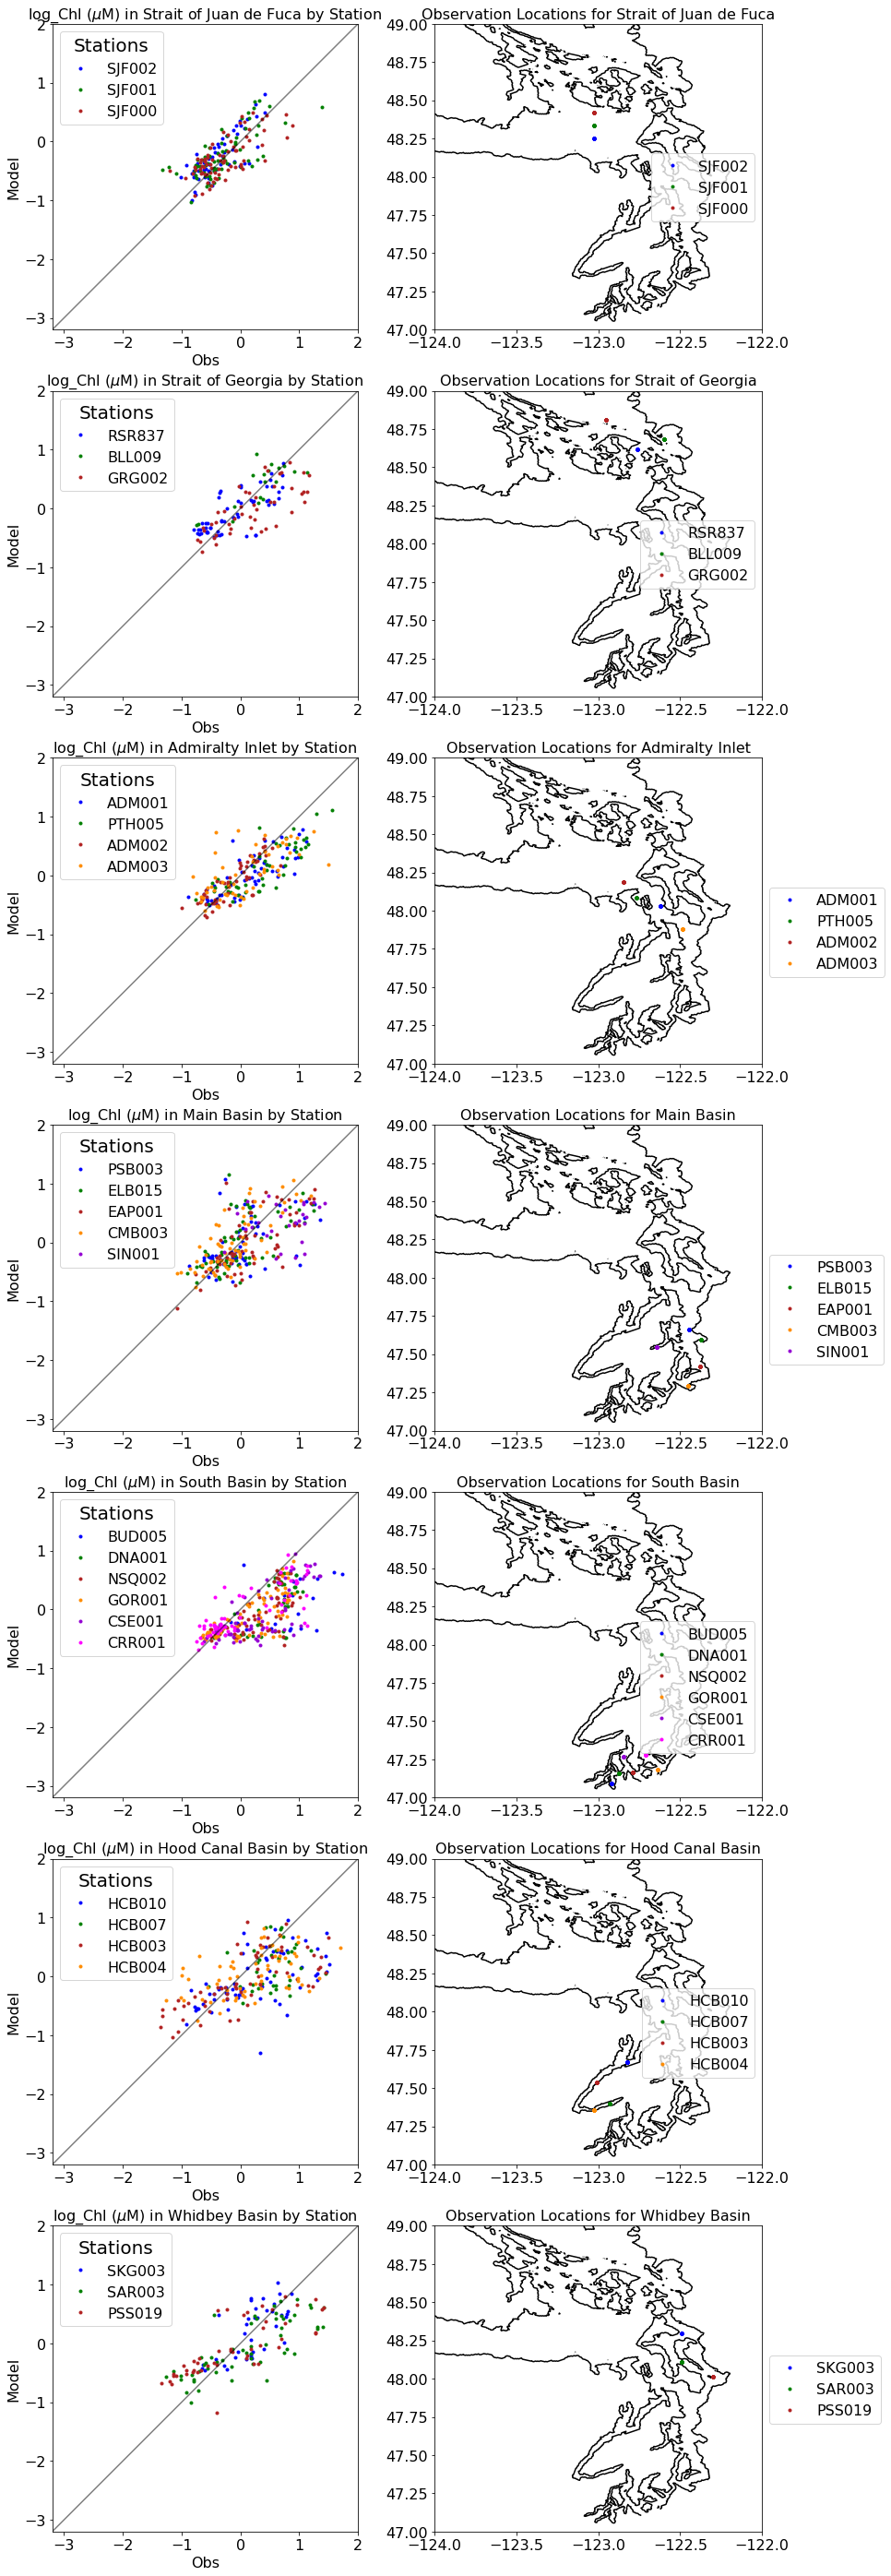

In [46]:
regions=['Strait of Juan de Fuca','Strait of Georgia','Admiralty Inlet','Main Basin','South Basin','Hood Canal Basin','Whidbey Basin']

ax=ket.multi_station_graph(data,datstat,obsvar,modvar,regions,lims,figsize=(14,50))

## Model Chlorophyll vs observed Chlorophyll comparisons for multiple seasons

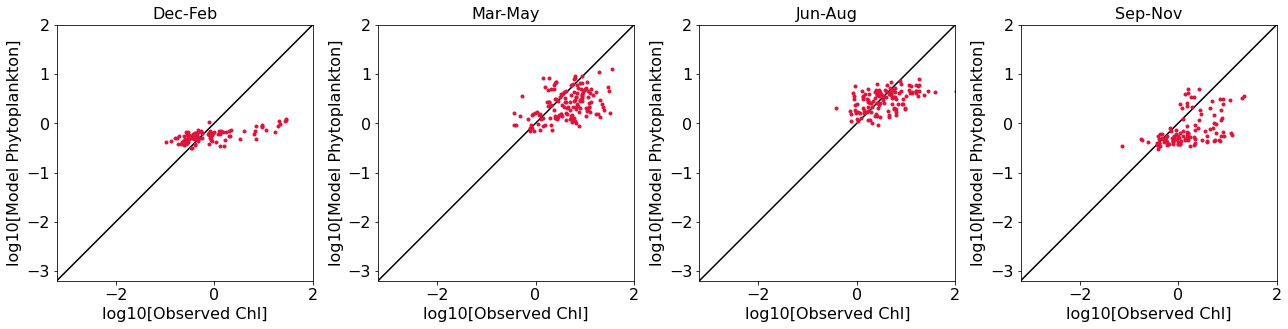

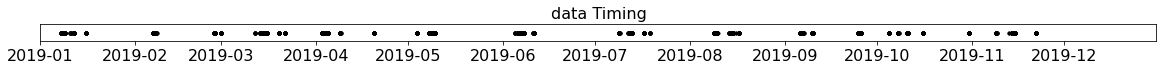

In [47]:
seasons=[DJF,MAM,JJA,SON]
fig, ax = plt.subplots(1,4,figsize = (18,5))
ket.bySeason(ax,seasons,obsvar,modvar,lims)
for i in range(4):
        ax[i].set_ylabel('log10[Model Phytoplankton]')
        ax[i].set_xlabel('log10[Observed Chl]')  
plt.tight_layout()
fig,ax=plt.subplots(1,1,figsize=(20,.3))
ax.plot(data.dtUTC,np.ones(np.shape(data.dtUTC)),'k.')
ax.set_xlim((dt.datetime(year,1,1),dt.datetime(year,12,31)))
ax.set_title('data Timing')
ax.yaxis.set_visible(False)

### Summary table of evaluation statistics for Temperature, Salinity, and Chlorophyll.

In [48]:
tbl,tdf=et.displayStats(statsDict_Chl,level='Variable',suborder=list(statsubs.keys()))
tbl